In [2]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks

imports work


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data -->

In [3]:
# hit_data_1096 = rf.get_ROOT_data_zip("TB_FIRE_1096_hits.root")

hit_data_1101 = rf.get_ROOT_data_zip("TB_FIRE_1101_hits.root")

# hit_data_1056 = rf.get_ROOT_data_zip("TB_FIRE_1056_hits.root")

# hit_data_1057 = rf.get_ROOT_data_zip("TB_FIRE_1057_hits.root")

# hit_data_1079 = rf.get_ROOT_data_zip("TB_FIRE_1079_hits.root")

TB_FIRE_1101_hits.root finished


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Hit Counts and Amp in Single Planes -->

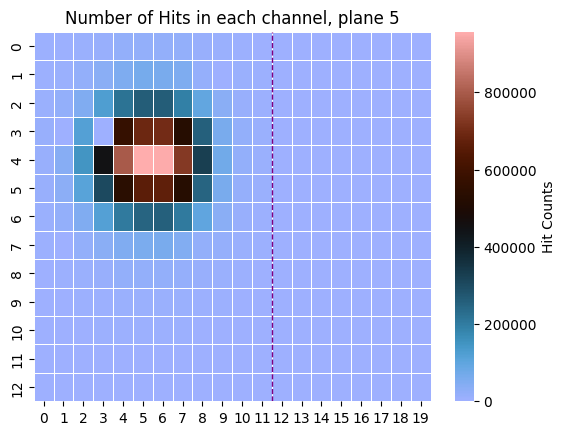

In [53]:
rf.hits_amount_colormap_single_plane(hit_data_1101, 5)

In [5]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 7, cmap="managua")

In [6]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 0, cmap="managua")

In [7]:
# rf.single_event_evolution_amp(hit_data_1101, 54106, cmap="managua")

In [8]:
# plt.clf()   # Clear the current figure
# plt.close() # Close any open figures
# %matplotlib widget
# rf.amp_histo_single_plane(hit_data_1101,1)

In [9]:
# rf.average_amp_vs_plane(hit_data_1101)

In [10]:
# # shower initial starting points
# rf.plot_empty_first_planes(hit_data_1101)

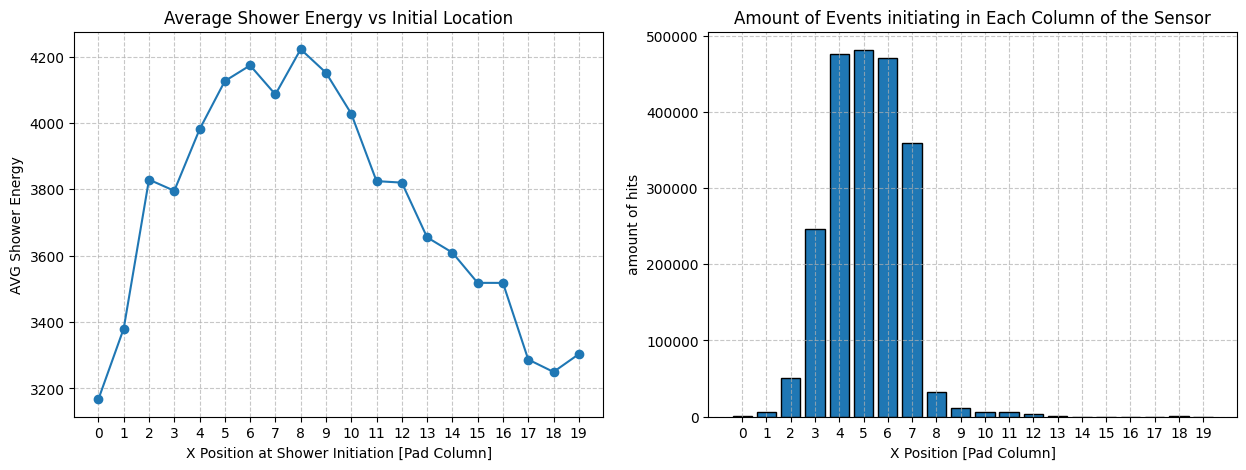

In [11]:
rf.event_shower_energy_vs_X_position(hit_data_1101)

In [12]:
# returns histogram of the amount of hits with the same energy in given X position
def shower_energy_histo_single_location(hit_data, Position):

    # get only showers starting at the first plane to identify the initial location
    plane_7 = hit_data_1101[hit_data_1101.plane == 7]
    mask = ak.num(plane_7) > 0
    first_plane_starting_events = hit_data_1101[mask]

    # determine the initial location of the shower
    # get the data on the first plane
    plane_7_clean = plane_7[mask]
    plane_7_channel = plane_7_clean.ch
    # divide by x positions
    y, x = divmod(plane_7_channel, 20) #y is the quontinent and is the row, x is the remainder and column
    x_list = x.to_list()
    x_ak = ak.Array(x_list)
    x_avg = ak.mean(x_ak, axis = 1)
    print("avg ok")
    # compute the shower energy for each event
    hit_amp_array = first_plane_starting_events.amp
    event_shower_amp_array = ak.sum(hit_amp_array, axis = 1)
    print("shower per event ok")
    # get the shower energy for the X position for all events
    amps_divided_by_class, avg_amps, classes = rf.ak_groupby(x_avg, event_shower_amp_array)
    print("groupby ok")
    # div, avg_amps, classes = ak_groupby(x_avg, event_shower_amp_array)

    amps_class_position = amps_divided_by_class[amps_divided_by_class.classes == Position]
    print("amps class at position ok")
    amps_position = amps_class_position.data
    print("amp position ok")
    amps_position_clean = amps_position[ak.num(amps_position) > 0]
    print("amp position clean ok")




    # Plot
    plt.hist(amps_position_clean[0], bins=100, range=(0,500))
    plt.show()



In [13]:
# shower_energy_histo_single_location(hit_data_1101,5)


In [14]:
# get the columns with the maximum amount of hits, k is the amount of wanted columns
def columns_with_max_hits(hit_data, number_of_columns):

    # get the initial x positions
    x_avg = rf.initial_X_position_DUT(hit_data)
    # x_avg = ak.round(x_avg)

    x_avg_np = ak.to_numpy(x_avg)

    # Compute histogram for X positions
    counts, bin_edges = np.histogram(x_avg, bins=np.arange(0, 21))

    # get the positions with the highest entries
    bins = np.arange(0, 20)

    # Get indices that would sort counts descending
    top_indices = np.argsort(-counts)[:number_of_columns]

    # Get the corresponding bin numbers
    top_bins = bins[top_indices]
    top_counts = counts[top_indices]

    return top_bins
    


In [ ]:
def avg_hit_amount_vs_plane_per_X_position(hit_data, number_of_highest_ocupied_columns):
    
    planes = np.arange(0,8)

    # attach the positions to the data
    positions = rf.initial_X_position_DUT(hit_data)
    plane_7 = hit_data[hit_data.plane == 7]
    mask = ak.num(plane_7) > 0
    events_starting_at_7 = hit_data[mask]
    hit_data_positions = ak.zip({ "hits":events_starting_at_7, "positions":positions},depth_limit=1)
    
    # get the most ocupied columns
    top_columns = columns_with_max_hits(hit_data, number_of_highest_ocupied_columns)
    print(top_columns)

    # array to store all the data of planes per column
    total_avg_amount = []

    # plt.figure(figsize=(8, 5))
    for column in top_columns:
        print(column)
        # creat an array to store the amount of hits in each plane
        hits_amount_plane_array = []

        # get the data of events initiating in the wanted column
        hit_data_column = hit_data_positions[(hit_data_positions.positions >= column) & (hit_data_positions.positions < column + 1)]


        # find the amount of hits in a plane for the column and add to the array
        for plane in planes:
            plane = 7-plane #adjust index so the first plane is 0
            hit_data_column_plane = hit_data_column.hits[hit_data_column.hits.plane == plane] # the events initiatin at the wanted column and a specific plane 
            hit_data_column_plane = hit_data_column_plane[ak.num(hit_data_column_plane) > 0] # clean from empty entries
            num_of_events_column_plane = len(hit_data_column_plane)
            num_of_hits_column_plane = len(ak.flatten(hit_data_column_plane))
            avg_hits_per_event_column_plane = num_of_hits_column_plane / num_of_events_column_plane
            hits_amount_plane_array.append(avg_hits_per_event_column_plane)
        total_avg_amount.append(hits_amount_plane_array)
        print(hits_amount_plane_array)

        # plot avg amount of hits per plane
        plt.plot(planes, hits_amount_plane_array, label=f"X Position: {column} Column", marker=".")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.xlabel("Plane")
        plt.ylabel("Average Amount of Hits")
        plt.title("Amount of Hits in a Shower for each plane, for events initiating at different columns")
        plt.legend()

    plt.show()





    # divide the amount of hits by the amount of events to get the avg hit per shower in a plane

[5 4 6 7 3 2]
5
[1.8404552836061723, 3.2004513468335802, 3.982335392687881, 4.994403087834661, 6.709466995639977, 6.379445797934801, 6.809896368063093, 6.808746405536777]
4
[1.711455987035315, 3.0490551548708282, 3.639604234954624, 4.820518363616516, 6.67514262980582, 6.015625032983132, 6.91655703099552, 6.674603625737642]
6
[1.8777883155490722, 3.2664270529706982, 4.105078616148392, 4.964837384279325, 6.699953368681024, 6.442541852046551, 6.7597643277986075, 6.797581296955403]
7
[1.6286689818679667, 3.0874899981003585, 3.8166402868310727, 4.6607215437044704, 6.652465806422248, 6.307588397998652, 6.7823943602729, 6.721187568531275]
3
[1.8254943912826362, 3.037830936133871, 3.68197935610307, 4.759995197005582, 6.677738353374072, 5.703830388923625, 6.895078048900276, 6.5608561544761494]
2
[2.198269048371799, 3.1603290488431877, 3.871015282740799, 4.838305597579425, 6.574597719106389, 5.640643053508108, 6.860022754036845, 6.4659436871953035]


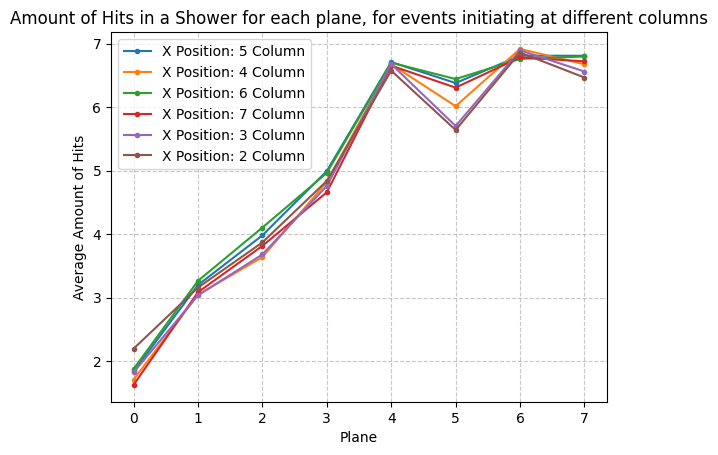

In [57]:
avg_hit_amount_vs_plane_per_X_position(hit_data_1101,6)

In [66]:
a = []
b= np.arange(0,7)
c = b+1
a.append(b)
a.append(c)
a_np = np.array(a)
print(a_np)
np.transpose(a_np)[0]

[[0 1 2 3 4 5 6]
 [1 2 3 4 5 6 7]]


array([0, 1])